In [1]:
# Migrate to DAS data analysis

In [37]:
import os
print(os.listdir())
import numpy as np
import matplotlib.pyplot as plt
from pds.DSS_analyzer_Mariner import Data1D_GAUGE, Data1D_PumpingCurve
from scipy.interpolate import interp1d

['243_22562_220-pycharm-support-libs', '._.DS_Store', 'data', 'pds', '.DS_Store']


In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Specify the datapath
datapath = "./data"

# Pressure gauge data (Only S well)
gauge_data_foler = datapath + "/gauge_data_swell"
# Load the pressure gauge data. Most close to the first stage is gauge 6. For the stage 8 I need to use gauge 7.
gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE(gauge_data_foler + f"/gauge6_data_swell.npz")
gauge_dataframe_next = Data1D_GAUGE.Data1D_GAUGE(gauge_data_foler + f"/gauge7_data_swell.npz")

# Load the pumping curve data (stage7; stage8)
pumping_curve_filepath = datapath + f"/pumping_curve/pumping_curve_stage7.npz"
pumping_curve_dataframe = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath)

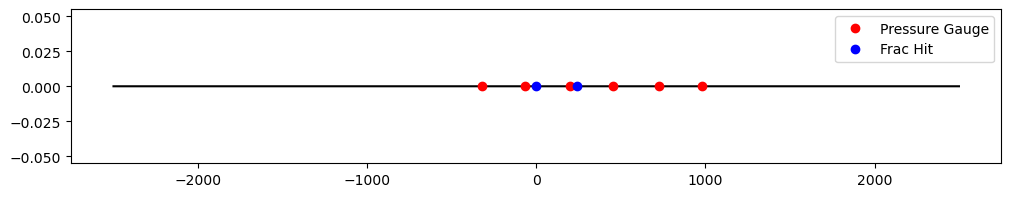

In [7]:
# Configuration from previous file
stage7_start_time = pumping_curve_dataframe.get_start_time()
stage7_end_time = pumping_curve_dataframe.get_end_time()
pumping_curve_filepath_next = datapath + f"/pumping_curve/pumping_curve_stage8.npz"
pumping_curve_dataframe_next = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath_next)
stage8_start_time = pumping_curve_dataframe_next.get_start_time()
stage8_end_time = pumping_curve_dataframe_next.get_end_time()
# Crop the pressure gauge data
gauge_dataframe.crop(stage7_start_time, stage8_end_time)
gauge_md_idx = np.array([265, 520, 789, 1043, 1312, 1567])
frac_hit_idx = np.array([589, 830])
# Simulator parameters
nx = 5000
# nx = 1800
total_time = 13000
d = 140 * np.ones(nx)
dx = 1
x = np.arange(0, nx * dx, dx)
x = x - nx * dx / 2  # make the center of the domain as 0
t = list([0])  # store the time points
dt = 0
dt_init = 10.0
# Pre-processing the idx of pg and frac hit
# Update the idx of pg and frac hit, make the first frac hit -> x=0
gauge_md_idx = gauge_md_idx - frac_hit_idx[0] + nx // 2
frac_hit_idx = frac_hit_idx - frac_hit_idx[0] + nx // 2
# Plot the location of the pressure gauge and frac hit
plt.figure(figsize=(12, 2))
plt.plot(x, np.zeros(nx), 'k')
plt.plot(x[gauge_md_idx], np.zeros(gauge_md_idx.size), 'ro', label='Pressure Gauge')
plt.plot(x[frac_hit_idx], np.zeros(frac_hit_idx.size), 'bo', label='Frac Hit')
plt.legend()
plt.show()

# Phase 1

In [11]:
from pds.core import pds

In [12]:
pds_frame_phase1 = pds.PDS1D_SingleSource()
# Initialize the simulator
pds_frame_phase1.set_mesh(x)
pds_frame_phase1.set_diffusivity(d)
pds_frame_phase1.set_bcs('Neumann', 'Neumann')
pds_frame_phase1.set_t0(0)  # Phase 1 starts at 0
pds_frame_phase1.set_sourceidx(frac_hit_idx[0])  # The source is at the first frac hit
# Process the pressure gauge data to get the source term
phase_1_pg_dataframe = gauge_dataframe.copy()
phase_1_pg_dataframe.crop(stage7_start_time, stage7_end_time)
pds_frame_phase1.set_source(phase_1_pg_dataframe)
# Set the initial condition
u_initial = np.zeros(nx)
u_initial += phase_1_pg_dataframe.data[0]
pds_frame_phase1.set_initial(u_initial)
pds_frame_phase1.solve(optimizer=True, dt_init=2, print_progress=True,
                       max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)

Message from pds: Source set done.
Also, just a reminder: please make sure the data is cropped properly.
Time array generated using the source term.
Time: 2 Source term: 9604.148
Time: 32 Source term: 9604.07056412729
Time: 62 Source term: 9603.273238642298
Time: 92 Source term: 9602.47516989796
Time: 122 Source term: 9601.682737190813
Time: 152 Source term: 9600.86372284264
Time: 182 Source term: 9600.477121347203
Time: 212 Source term: 9602.09012320917
Time: 242 Source term: 9605.704453693117
Time: 272 Source term: 9611.268763054188
Time: 302 Source term: 9616.494262443439
Time: 332 Source term: 9621.314572556763
Time: 362 Source term: 9625.443425714788
Time: 392 Source term: 9629.296163234554
Time: 422 Source term: 9632.833562058528
Time: 452 Source term: 9636.232628516005
Time: 482 Source term: 9639.377741415557
Time: 512 Source term: 9642.409783458646
Time: 542 Source term: 9645.273221063608
Time: 572 Source term: 9648.107563106796
Time: 602 Source term: 9650.693380610828
Time: 63

# Phase 2

In [13]:
# Calculate the total_time
total_time = stage8_start_time - stage7_start_time
# convert the datetime to seconds
total_time = total_time.total_seconds()
# Initialize the simulator: Phase 2
pds_frame_phase2 = pds.PDS1D_SingleSource()
pds_frame_phase2.set_mesh(x)
pds_frame_phase2.set_diffusivity(d)
pds_frame_phase2.set_bcs('Neumann', 'Neumann')
pds_frame_phase2.set_t0(pds_frame_phase1.taxis[-1])  # Phase 2 starts after phase 1
pds_frame_phase2.set_sourceidx(frac_hit_idx[0])  # The source is at the first frac hit
# Process the pressure gauge data to get the source term
phase_2_pg_dataframe = gauge_dataframe.copy()
phase_2_pg_dataframe.crop(stage7_end_time, stage8_start_time)
# Set the source term
pds_frame_phase2.set_source(phase_2_pg_dataframe)
# Set the initial condition
u_initial = pds_frame_phase1.snapshot[-1]
pds_frame_phase2.set_initial(u_initial)
pds_frame_phase2.solve(optimizer=True,
                       dt_init=2,
                       t_total=total_time,  # Phase 2 ends at the start of stage 8
                       print_progress=True,
                       max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)  # optional parameters

Message from pds: Source set done.
Also, just a reminder: please make sure the data is cropped properly.
Time array generated using t_total.
Time: 14524 Source term: 10156.084
Time: 14527.354675046096 Source term: 10154.145334322453
Time: 14535.056448232812 Source term: 10151.246661278727
Time: 14552.378479468407 Source term: 10146.163369540107
Time: 14582.378479468407 Source term: 10134.283990203416
Time: 14612.378479468407 Source term: 10116.83086847015
Time: 14642.378479468407 Source term: 10101.81669923289
Time: 14672.378479468407 Source term: 10088.556356521443
Time: 14702.378479468407 Source term: 10076.465654042055
Time: 14732.378479468407 Source term: 10065.364876233609
Time: 14762.378479468407 Source term: 10055.13554025103
Time: 14792.378479468407 Source term: 10045.21382325798
Time: 14822.378479468407 Source term: 10038.240231385766
Time: 14852.378479468407 Source term: 10028.872581346432
Time: 14882.378479468407 Source term: 10022.726526216848
Time: 14912.378479468407 Sourc

In [85]:
# Phase 3
# Change diffusivity ratio
diffusivity_change_ratio = np.array([1, 0.5, 0.1, 0.01, 0.001])
total_time = stage8_end_time - stage7_start_time
# convert the datetime to seconds
total_time = total_time.total_seconds()
# Initialize the simulator: Phase 3
pds_frame_phase3 = pds.PDS1D_SingleSource()
pds_frame_phase3.set_mesh(x)
pds_frame_phase3.set_bcs('Neumann', 'Neumann')
pds_frame_phase3.set_t0(pds_frame_phase2.taxis[-1])  # Phase 3 starts after phase 2
pds_frame_phase3.set_sourceidx(frac_hit_idx[1])  # The source is at the second frac hit
# Change the diffusivity at the first frac hit
d[frac_hit_idx[0]] = diffusivity_change_ratio[-2] * d[frac_hit_idx[0]]
pds_frame_phase3.set_diffusivity(d)
# Process the pressure gauge data to get the source term
phase_3_pg_dataframe = gauge_dataframe_next.copy()
phase_3_pg_dataframe.crop(stage8_start_time, stage8_end_time)
# Set the source term
pds_frame_phase3.set_source(phase_3_pg_dataframe)
# Set the initial condition
u_initial = pds_frame_phase2.snapshot[-1]
pds_frame_phase3.set_initial(u_initial)
pds_frame_phase3.solve(optimizer=True,
                       dt_init=2,
                       t_total=total_time,  # Phase 3 ends at the end of stage 8
                       print_progress=True,
                       max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)  # optional parameters

Message from pds: Source set done.
Also, just a reminder: please make sure the data is cropped properly.
Time array generated using t_total.
Time: 23734.378479468407 Source term: 9530.631
Time: 23738.11064836754 Source term: 9530.574
Time: 23747.33343877886 Source term: 9530.478004998322
Time: 23769.411190246577 Source term: 9530.230112420528
Time: 23799.411190246577 Source term: 9529.60507272868
Time: 23829.411190246577 Source term: 9528.78824532982
Time: 23859.411190246577 Source term: 9527.949187349202
Time: 23889.411190246577 Source term: 9527.12667549132
Time: 23919.411190246577 Source term: 9526.541026166435
Time: 23949.411190246577 Source term: 9527.793960446215
Time: 23979.411190246577 Source term: 9531.025341367205
Time: 24009.411190246577 Source term: 9534.551456958694
Time: 24039.411190246577 Source term: 9537.964600484325
Time: 24069.411190246577 Source term: 9541.561707045772
Time: 24099.411190246577 Source term: 9545.043049941265
Time: 24129.411190246577 Source term: 9548

# Post-Processing

## Combine the results

In [17]:
# Combine the results -> snapshot
snapshot_result_all = np.concatenate([pds_frame_phase1.snapshot, pds_frame_phase2.snapshot], axis=0)
snapshot_result_all = np.concatenate([snapshot_result_all, pds_frame_phase3.snapshot], axis=0)
# Combine the results -> taxis
taxis_result_all = np.concatenate([pds_frame_phase1.taxis, pds_frame_phase2.taxis], axis=0)
taxis_result_all = np.concatenate([taxis_result_all, pds_frame_phase3.taxis], axis=0)

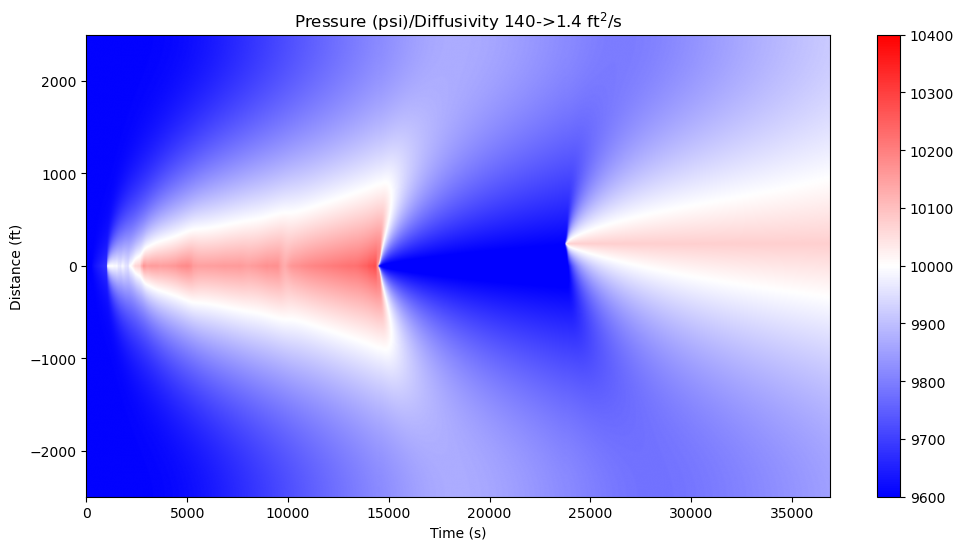

In [90]:
# Plot the solution
plt.figure(figsize=(12, 6))
plt.imshow(snapshot_result_all.T, aspect='auto', cmap='bwr', extent=[taxis_result_all[0], taxis_result_all[-1], x[-1], x[0]])
plt.colorbar()
plt.ylabel('Distance (ft)')
plt.xlabel('Time (s)')
plt.title('Pressure (psi)/Diffusivity 140->1.4 ft$^2$/s')
plt.gca().invert_yaxis()
plt.clim([9600, 10400])
plt.show()

In [45]:
# Pack the results
pds_frame_phase1.pack_result(filename="Phase1.npz", mode="dss_analyzer_mariner")
pds_frame_phase2.pack_result(filename="Phase2.npz", mode="dss_analyzer_mariner")
pds_frame_phase3.pack_result(filename="Phase3.npz", mode="dss_analyzer_mariner")

0

In [46]:
os.listdir()

['243_22562_220-pycharm-support-libs',
 'Phase1.npz',
 '._.DS_Store',
 'data',
 'Phase2.npz',
 'pds',
 '.DS_Store',
 'Phase3.npz']

# Alternative way to read the data

In [143]:
from pds.DSS_analyzer_Mariner import Data2D_PFSnapshot
phase1_data = Data2D_PFSnapshot.Data2D_PFSnapshot()
phase1_data.load_snapshot(file = "Phase1.npz")

phase2_data = Data2D_PFSnapshot.Data2D_PFSnapshot()
phase2_data.load_snapshot(file = "Phase2.npz")

phase3_data = Data2D_PFSnapshot.Data2D_PFSnapshot()
phase3_data.load_snapshot(file = "phase3_new.npz")

In [144]:
# Combine the results -> snapshot
snapshot_result_all = np.concatenate([phase1_data.data, phase2_data.data], axis=0)
snapshot_result_all = np.concatenate([snapshot_result_all, phase3_data.data], axis=0)
# Combine the results -> taxis
taxis_result_all = np.concatenate([phase1_data.taxis, phase2_data.taxis], axis=0)
taxis_result_all = np.concatenate([taxis_result_all, phase3_data.taxis], axis=0)

## Convert pressure to strain rate

Then we can evaluate whether the simulation results are consistent with the DAS data, too.

In [145]:
from pds.DSS_analyzer_Mariner import Data2D_PFSnapshot

In [146]:
# Load the synthetic data
synthetic_data = Data2D_PFSnapshot.Data2D_PFSnapshot()
synthetic_data.load_snapshot(data=snapshot_result_all, taxis=taxis_result_all, daxis=x)

In [147]:
pressure_field_pa = synthetic_data.data * 6894.76
strain_from_pressure = pressure_field_pa / 30e9

In [148]:
# Perform the gradient calculation along time
strain_rate_from_pressure = np.zeros_like(strain_from_pressure)
for i in range(strain_from_pressure.shape[1]):
    # calculate the gradient along time
    strain_rate_from_pressure[:, i] = np.gradient(strain_from_pressure[:, i], axis=0) / np.gradient(taxis_result_all)

In [149]:
synthetic_data.daxis.shape

(5000,)

In [150]:
synthetic_data.taxis.shape

(1240,)

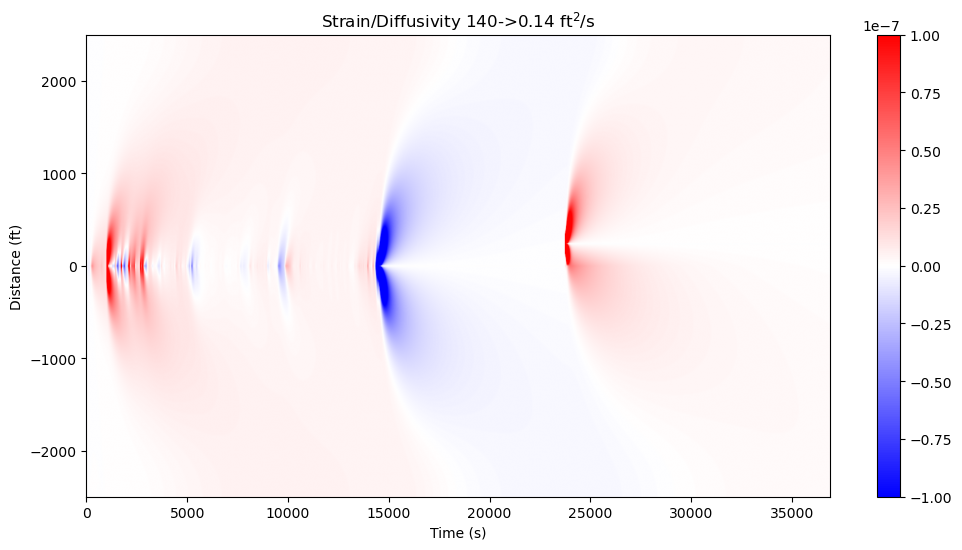

In [159]:
# Plot the solution
ax  = np.array([-1, 1])
plt.figure(figsize=(12, 6))
plt.imshow(strain_rate_from_pressure.T, aspect='auto', cmap='bwr', extent=[taxis_result_all[0], taxis_result_all[-1], x[-1], x[0]])
plt.clim(ax * 1e-7)
plt.colorbar()
plt.ylabel('Distance (ft)')
plt.xlabel('Time (s)')
plt.title('Strain/Diffusivity 140->0.14 ft$^2$/s')
plt.gca().invert_yaxis()
plt.show()

In [160]:
# Get the value of the pressure at the pressure gauge location
synthetic_DAS_value = []
for pg in gauge_md_idx:
    synthetic_DAS_value.append(strain_rate_from_pressure[:, pg])

# Load the DAS data

In [161]:
# Compare the results with the DAS data
DASdata_folder = datapath + "/DASdata/"
os.listdir(DASdata_folder)

['LFDASdata_stg8_swell.npz',
 'LFDASdata_stg7_interval_swell.npz',
 'LFDASdata_stg7_swell.npz']

In [162]:
# Load data
from pds.DSS_analyzer_Mariner import Data2D_XT_DSS

In [163]:
# add path
import sys
sys.path.append("./pds/DSS_analyzer_Mariner")

In [164]:
stg7_DASdata = Data2D_XT_DSS.Data2D()
stg7_DASdata.loadnpz(DASdata_folder + "LFDASdata_stg7_swell.npz")

In [165]:
stg7_DASdata_interval = Data2D_XT_DSS.Data2D()
stg7_DASdata_interval.loadnpz(DASdata_folder + "LFDASdata_stg7_interval_swell.npz")

In [166]:
stg8_DASdata = Data2D_XT_DSS.Data2D()
stg8_DASdata.loadnpz(DASdata_folder + "LFDASdata_stg8_swell.npz")

In [167]:
# merge the DAS data
# DASdata_new = Data2D_XT_DSS.merge_data2D([DASdata, DASdata_interval, DASdata_next])
DASdata_all = Data2D_XT_DSS.merge_data2D([stg7_DASdata, stg7_DASdata_interval, stg8_DASdata])

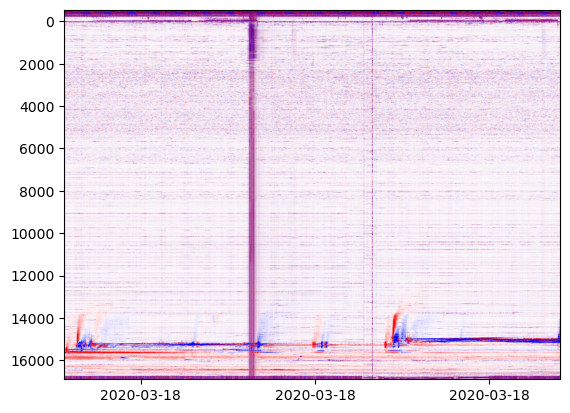

In [168]:
cx = np.array([-1, 1])
DASdata_all.plot_waterfall(downsample=[4,4], use_timestamp=True)
plt.clim(cx * 1e3)
plt.show()

In [169]:
from pds.DSS_analyzer_Mariner import Data3D_geometry

In [170]:
geometry_data = datapath + "/geometry/"
# Load the geometry data
stg7_geometry_path = geometry_data + "frac_hit/frac_hit_stage_7_swell.npz"
stg7_frachit_dataframe = Data3D_geometry.Data3D_geometry(stg7_geometry_path)

In [171]:
stg8_geometry_path = geometry_data + "frac_hit/frac_hit_stage_8_swell.npz"
stg8_frachit_dataframe = Data3D_geometry.Data3D_geometry(stg8_geometry_path)

In [172]:
stg7_frac_hit = np.mean(stg7_frachit_dataframe.data)
stg8_frac_hit = np.mean(stg8_frachit_dataframe.data)

DASdata_all.select_depth(stg7_frac_hit - 500, stg8_frac_hit + 500)

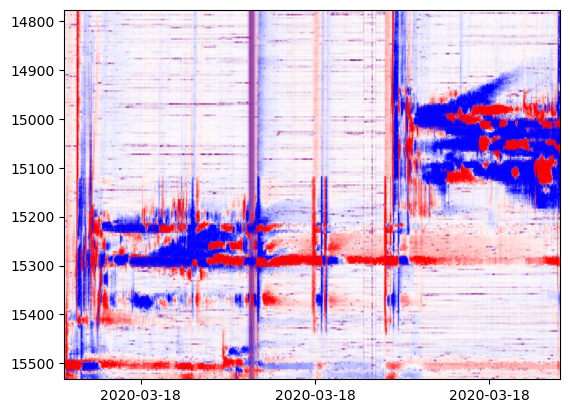

In [173]:
cx = np.array([-1, 1])
DASdata_all.plot_waterfall(use_timestamp=True)
plt.clim(cx * 1e3)
plt.show()

In [174]:
gauge_md_true_dataframe = Data3D_geometry.Data3D_geometry(geometry_data + "gauge_md_swell.npz")

In [175]:
gauge_md_true = gauge_md_true_dataframe.data[4:10]

In [176]:
md_all, DASchannel_all = [], []
for idx in gauge_md_true:
    md, DASchannel = DASdata_all.get_value_by_depth(idx)
    md_all.append(md)
    DASchannel_all.append(DASchannel)

In [177]:
gauge_num = [5, 6, 7, 8, 9, 10]

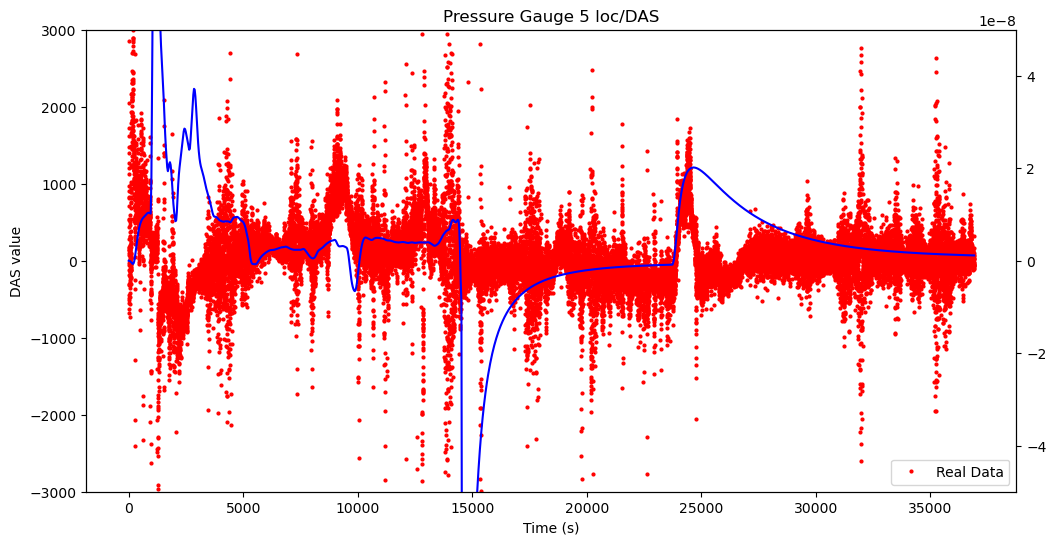

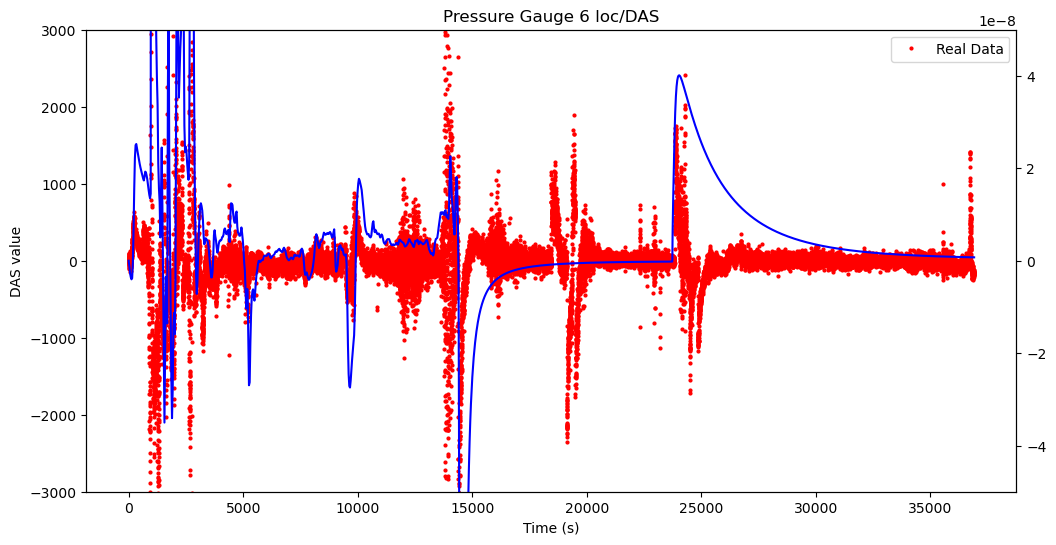

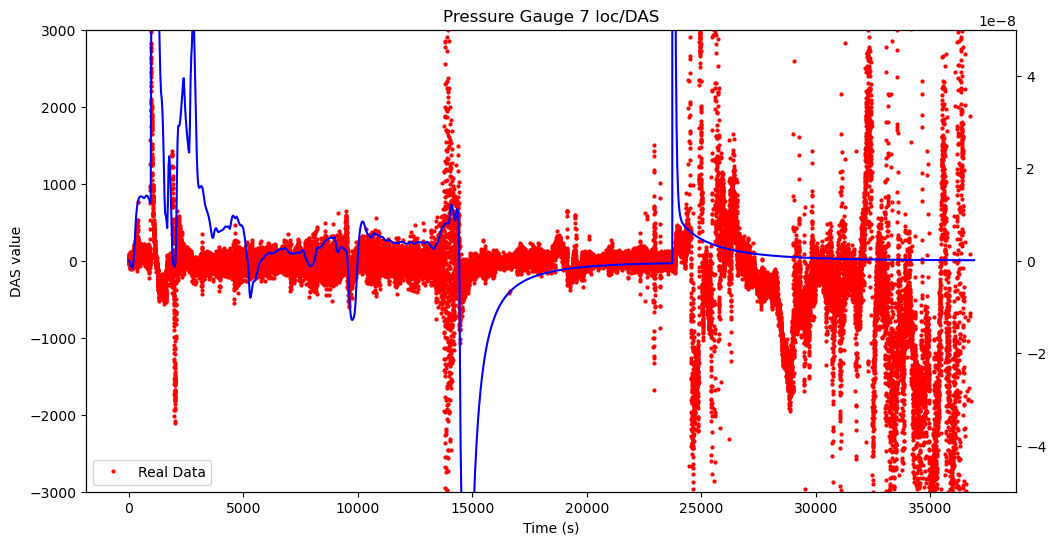

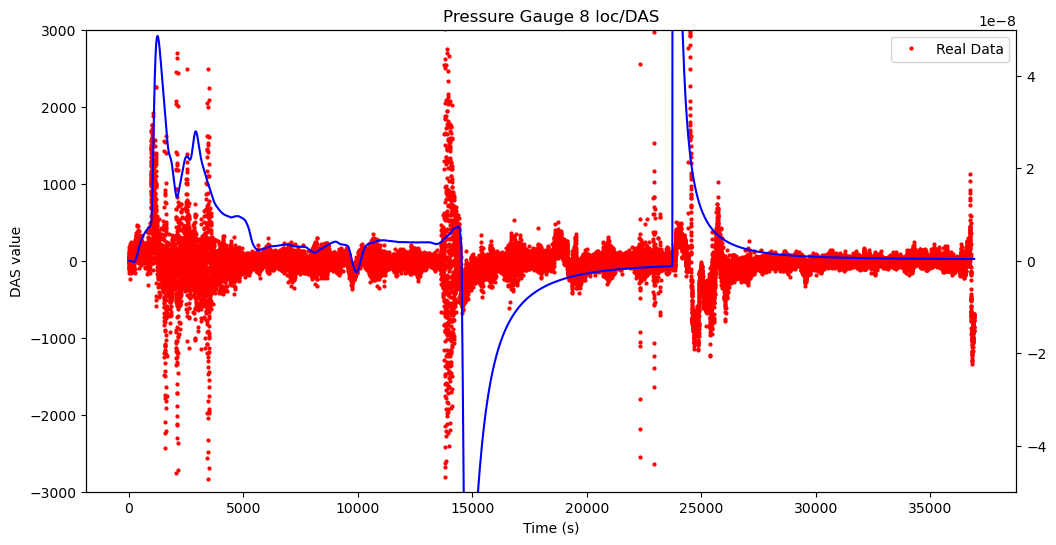

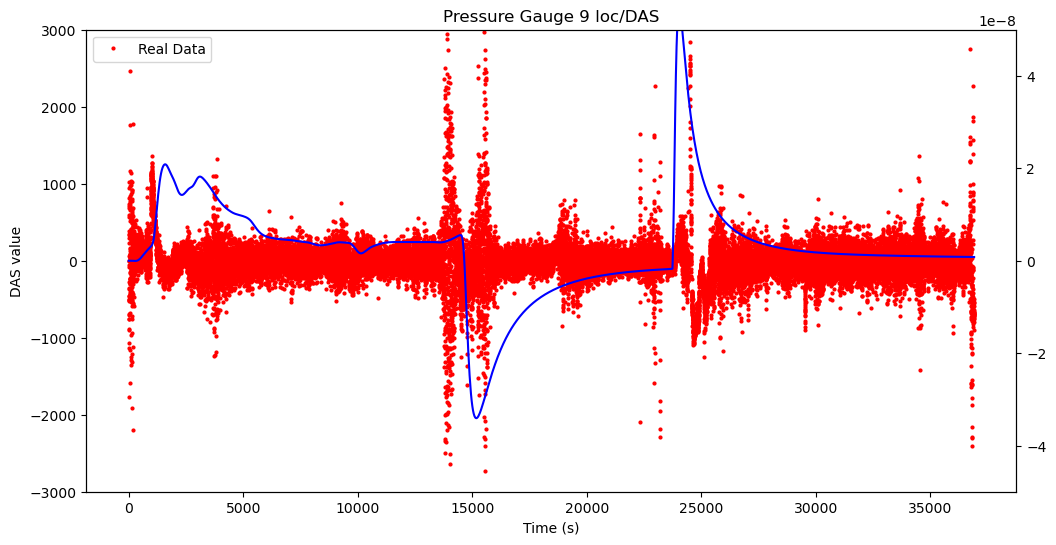

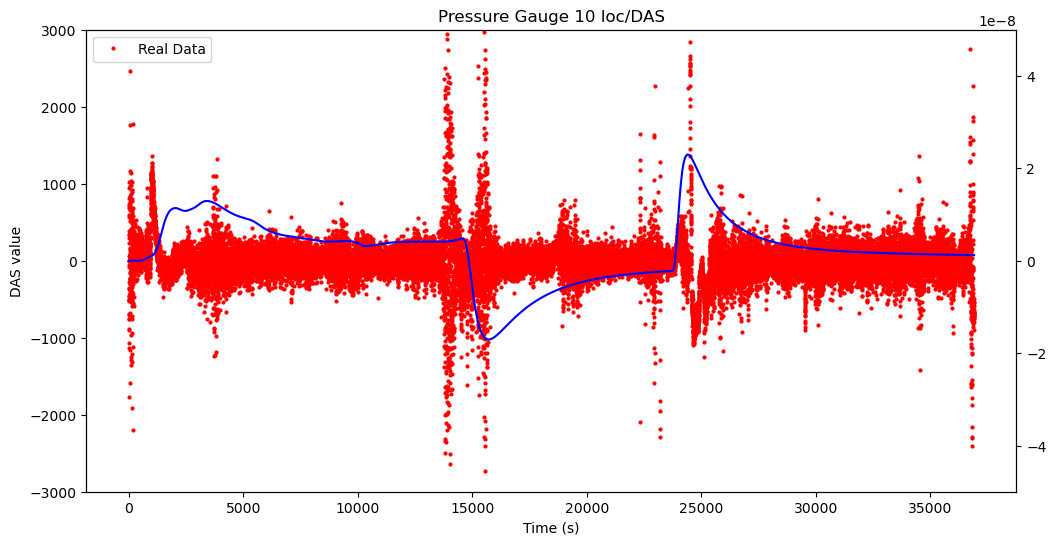

In [179]:
# Compare the simulation and real data
for i in range(len(gauge_num)):
    plt.figure(figsize=(12, 6))
    plt.plot(DASdata_all.taxis, DASchannel_all[i], 'ro', label='Real Data', markersize=2)
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('DAS value')
    plt.title(f'Pressure Gauge {gauge_num[i]} loc/DAS')
    plt.ylim(cx * 3000)

    plt.twinx()
    plt.plot(taxis_result_all, synthetic_DAS_value[i], 'b-', label='Simulation')
    plt.ylim(cx * 5e-8)
    plt.show()